# Lognormal distributions in inventories

Building on notebooks 1 and 2, we now look at the lognormal distribution, which is the basis for 99% of exchanges in ecoinvent which have uncertainty.

We start by importing the necessary libraries, and switching to the Brightway project that was set up in notebook 1.

In [7]:
%matplotlib inline

In [8]:
import seaborn as sb
import matplotlib.pyplot as plt

In [22]:
import bw2data as bwd
import bw_processing as bwp
import stats_arrays as sa
import pandas as pd
import numpy as np
from scipy import stats

In [10]:
bwd.projects.set_current("OASES uncertainty review")

In [11]:
db = bwd.Database("ecoinvent 3.6 cutoff")

In [12]:
package = bwp.load_package(db.filepath_processed())
technosphere_array = package['technosphere_matrix.npy']
biosphere_array = package['biosphere_matrix.npy']
all_array = np.hstack([technosphere_array, biosphere_array])

# Utility function to look up exchanges

In [37]:
def label_exchanges(array):
    rm = {j: i for i, j in bwd.mapping.items()}
    inputs = [bwd.get_activity(rm[i]) for i in array['row_value']]
    outputs = [bwd.get_activity(rm[i]) for i in array['col_value']]
    return pd.DataFrame([{
        'input name': i['name'],
        'input location': i.get('location'),
        'input unit': i['unit'],
        'output name': o['name'],
        'output location': o.get('location'),
        'output unit': o['unit'],
        'amount': r['amount'],
        'scale': r['scale'],
    } for i, o, r in zip(inputs, outputs, array)])

# The lognormal distribution

The lognormal distribution is characterized by two input parameters: $\mu$ and $\sigma$. Rather than rephrasing, you can read the [description in Wikipedia](https://en.wikipedia.org/wiki/Log-normal_distribution#Generation_and_parameters), it is dry but clear.

To do some sanity checks, we need to define a metric. Natural processes can sometimes have quite high variability, though the averaging effect should help us reduce uncertainty, as most ecoinvent processes are the average of many places and times. 

One possible metric is to raise a flag if there is a 1% chance that the sampled value is more than 100 times the median. $\sigma$ is scale-independent, but as the analytical formulae get complicated, we let the libraries do the math.

In [13]:
lognormal = all_array[all_array['uncertainty_type'] == sa.LognormalUncertainty.id]

In [16]:
mask = (sa.LognormalUncertainty.ppf(lognormal, np.ones(lognormal.shape) * 0.99).ravel() / lognormal['amount']) >= 100
lognormal.shape[0], mask.sum()

(376115, 1420)

That is quite a few exchanges with high uncertainty. Let's look at the split across technosphere and biosphere.

In [17]:
lognormal_t = technosphere_array[technosphere_array['uncertainty_type'] == sa.LognormalUncertainty.id]
lognormal_b = biosphere_array[biosphere_array['uncertainty_type'] == sa.LognormalUncertainty.id]

In [18]:
mask_t = (sa.LognormalUncertainty.ppf(lognormal_t, np.ones(lognormal_t.shape) * 0.99).ravel() / lognormal_t['amount']) >= 100
mask_b = (sa.LognormalUncertainty.ppf(lognormal_b, np.ones(lognormal_b.shape) * 0.99).ravel() / lognormal_b['amount']) >= 100
mask_t.sum(), mask_b.sum()

(14, 1406)

In [40]:
label_exchanges(lognormal_t[mask_t]).sort_values('scale', ascending=False)

,input name,input location,input unit,output name,output location,output unit,amount,scale
5,"market for aluminium, cast alloy",GLO,kilogram,skidder production,GLO,unit,117.000000,4.883827
1,"market for aluminium, cast alloy",GLO,kilogram,"forwarder production, with terrain chipper",GLO,unit,80.599998,4.494976
3,"market for aluminium, cast alloy",GLO,kilogram,"chipper production, mobile, diesel",RoW,unit,578.150024,4.494976
4,"market for aluminium, cast alloy",GLO,kilogram,forwarder production,GLO,unit,80.599998,4.494976
2,"market for aluminium, cast alloy",GLO,kilogram,energy wood harvester production,GLO,unit,626.974976,3.486625
0,"market for aluminium, cast alloy",GLO,kilogram,forestry harvester production,GLO,unit,41.395000,2.910022
7,market for enzymes,GLO,kilogram,"mango production, conditioned, wax treatment",RoW,kilogram,0.000155,2.458495
6,market for enzymes,GLO,kilogram,"mango production, conditioned, wax treatment",BR,kilogram,0.000155,2.458089
13,"heat production, mixed logs, at furnace 100kW",RoW,megajoule,concrete block production,BR,kilogram,0.021528,2.114640
8,"market for wood chips, wet, measured as dry mass",RoW,kilogram,clinker production,BR,kilogram,0.000274,2.064437


I am 99% sure that these values were entered incorrectly. Scale ($\sigma$) values should be close to zero, and more than 1 is already quite high. 4 is insane. Here is a plot of a standard (i.e. $\mu = 0$) distribution with various $\sigma$ values:

Text(0.5, 0, 'Value')

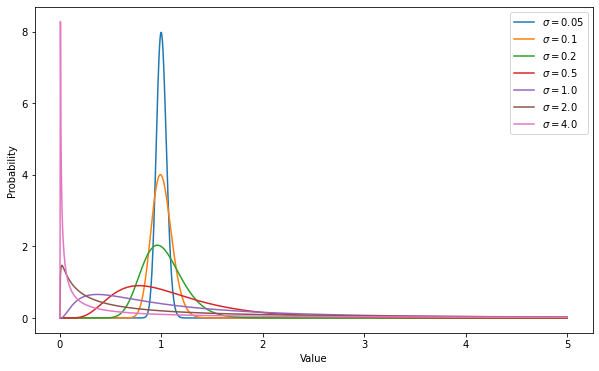

In [27]:
plt.figure(figsize=(10, 6))

xs = np.linspace(0, 5, 1000)

for s in [0.05, 0.1, 0.2, 0.5, 1., 2., 4.]:
    ys = stats.lognorm.pdf(xs, s, scale=np.ones_like(xs))
    plt.plot(xs, ys, label=f"$\sigma = {s}$")
    
plt.legend()
plt.ylabel("Probability")
plt.xlabel("Value")

Note how the *shape* of the distribution has to change to get the median in the right place when the tails are very long. Remember, the median of *all these distributions* is the same (one)! Imagine how long the tail has to be for the brown and pink distributions to have half their values more than one.

For a lit bit of context, the lines we commented out in notebook 1 fixed $\sigma$ values of more than **25**, which happily are not in the current version of ecoinvent, but were present in 3.1 or 3.2.

We can also see the effect of large lognormal uncertainties by looking at how the *mean* decreases with increasing uncertainty. The mean of a lognormal is:

$$exp{(\mu + \frac{\sigma^{2}}{2})}$$

Coming back to our table of technosphere exchanges, lets look at one case: aluminium inputs into [forwarder](https://en.wikipedia.org/wiki/Forwarder) production. The dataset is [available online](https://v36.ecoquery.ecoinvent.org/Details/UPR/09d1ca84-4f60-464a-b02b-a956f739c9dd/290c1f85-4cc4-4fa1-b0c8-2cb7f4276dce), but I copy one line from the description here: "This dataset contains a medium sized forwarder class II (10 - 12t), with a total weight of 11,049 kg..." Our basic value is around 80 kilograms of aluminium.

Let's calculate the chance that our RNG pulls a value of more than 11.049 kg of *just aluminium* for this vehicle:

In [29]:
1 - stats.lognorm.cdf(11049, 4.494976, scale=80.599998)

0.13682665952493323

As the Dutch say, "c'est pas bon." Let's get a little sillier. What is the chance that this specified distribution gives more atoms of aluminium than there are atoms in the sun? There are about $10^{57}$ [atoms in our sun](https://www.universetoday.com/36302/atoms-in-the-universe/). Aluminium in its metallic form is usually an alloy, but is still mosstly aluminium, which has an atomic weight of 26.9815. Avogadro's number is 6.02214076 × $10^{23}$, so we are looking for the following kilograms of aluminium:

$$10^{57} atoms \, / \, 6.02214076 \cdot 10^{23} \, \frac{atoms}{mol} \, / \, 26.9815 \, \frac{grams}{mol} \, / \, 1000 \, \frac{grams}{kg}$$

**edit**: OK, this went to far. Probability was zero.

What about this one loader using more aluminium than is produced worldwide in one year? According to [World Aluminium](http://www.world-aluminium.org/statistics/), 63.697.000 tons are produced per year.

In [36]:
1 - stats.lognorm.cdf(6.3697e10, 4.494976, scale=80.599998)

2.5826876882684147e-06

Only two in a million... still, that would be a big ass forwarder!